In [3]:
import pandas as pd
import json
import re
from fractions import Fraction
import os
import ast
from googletrans import Translator, constants
import typing
from textblob import TextBlob

In [2]:
df_full = pd.read_csv('../dataset/full_dataset.csv')

columns_to_remove = ['directions', 'link', 'source']
df_full = df_full.drop(columns_to_remove, axis=1)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


KeyboardInterrupt: 

In [11]:
# If you get a textblob error please run this and manually resolve your package issue.
# import nltk
# nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [60]:
df: pd.DataFrame = pd.DataFrame(df_full.loc[:5000])
df = df.dropna()
df = df[df['NER'] != '[]']

## Convert American untis to Europeans, remove fractions, cups, "1 package" etc. and return as a string

In [13]:
# -------THIS Section converts american units into european units and checks for
# fractions, cups, ounces etc. later on returning the recipe as a string again ----------------------------

unitConversions: dict = {
    'c ': '236.588 ml',
    'c.': '236.588 ml',
    'tsp.': '4.92892 ml',
    'tbsp.': '14.7868 ml',
    'oz.': '29.5735 ml',
    'pt.': '473.176 ml',
    'qt.':' 946.353 ml',
    'lb.': '453.592 grams',
    'gal.': '3785.41 ml',
    ' oz': ' 29.5735 ml',
}
europeanUnits: dict = {
    'ml': 'ml',
    'grams': 'grams',
}
def replace_units(text: str) -> str:
    # replaces american units with european units
    # 8-oz not only gets converted to 8-29.5735 ml but also 8 * 29.5735 ml so 240 ml
    text= text.lower()
    for key, value in unitConversions.items():
        if key in text:
            loc_key = text.find(key)
            if loc_key != -1 and loc_key-1 >= 0 and text[loc_key-1] == '-':
                text =text[:loc_key-1] +  ' ' + text[loc_key:]
                # text = text.replace('-', ' ', text[loc_key-1])
            text = text.replace(key, value)
    
    return text
def replace_fractions(text:str)-> str:
    # replaces fractions with decimals
    text = text.lower()
    text = re.sub(r'(?:(\d+)[-\s])?(\d+/\d+)', frac2string, text)
    return text
def frac2string(s):
    # helper function for replace_fractions
    i, f = s.groups(0)
    f = Fraction(f)
    return str(int(i) + float(f))


def convert_and_multiply_units(text: str) -> list:
    # converts units to floats within strings and multiplies them
    # e.g 1 0.5 0.24 ml becomes 0.12 ml
    ingredients: list = json.loads(text)
    ingredient_list = []
    for ingredient in ingredients: # ingredient is a string with units and one specific ingredient
        ingredient_split: list[str] = re.split(r'\s+|\)|\(', ingredient)
        # print("split ", ingredient_split)
        filtered_result = [item for item in ingredient_split if item]
        # print("filtered ", filtered_result)
        converted_values: list= []
        for index, item in enumerate(filtered_result):
            try: # try to turn it into a float and multiply
                converted_value = float(item)
                if len(converted_values) >= 1 and isinstance(converted_values[-1], float):
                    converted_value = converted_values[-1] * converted_value # multiply latest float with current
                    converted_values.pop(-1) # remove latest value, since were using it to multiply
                    converted_values.append(float(converted_value)) 
                else:
                    converted_values.append(converted_value)
            except ValueError:
                converted_values.append(item)
                pass
            except  IndexError:
                pass
        ingredient_string = " ".join(str(item) for item in converted_values) # join the list back together    
        ingredient_list.append(ingredient_string)
    return ingredient_list

def post_process_double_quantities(text):
    # sometimes we find double quantities, e.g. 100ml 20ml sugar
    ingredients: list = text
    ingredient_list = []
    for ingredient in ingredients: # ingredient is a string with units and one specific ingredient
        ingredient_split: list[str] = re.split(r'\s+|\)|\(', ingredient)
        filtered_result = [item for item in ingredient_split if item]
        converted_values: list= []
        for index, item in enumerate(filtered_result):
            try: # try to turn it into a float and multiply
                converted_value = float(item) # first unit 
                ml_1 = filtered_result[index+1]
                ml_2 = filtered_result[index-1]
                if ml_1 in europeanUnits.keys() and ml_2 in europeanUnits.keys() and index-1 >= 0 and index+1<=len(filtered_result) and ml_2 == ml_1: # check if followed by other unit
                    try:
                        converted_value = converted_value + float(filtered_result[index-2]) # add the second unit
                        converted_values.pop(-2) # remove latest value, since were using it to multiply
                        converted_values.append(float(converted_value)) 
                    except ValueError:
                        print('error:', filtered_result)
                else:
                    converted_values.append(converted_value)
            except ValueError:
                converted_values.append(item)
            except  IndexError as e:
                converted_values.append(item)
                pass
        
        ingredient_string = " ".join(str(item) for item in converted_values) # join the list back together    
        ingredient_list.append(ingredient_string)
    return ingredient_list

def remove_optional_quantitiy(text):
    # removing - here, and averaging it out. Different handling that usual (usually we multiply the values)
    ingredient_list = []
    for ingredient in text:
        if '-' in ingredient:
            loc_dash = ingredient.index('-')
            # checks for 6-7 cups by checking if before and after there is a number
            if ingredient[loc_dash-1].isdigit() and ingredient[loc_dash+1].isdigit() and loc_dash-1 >= 0 and loc_dash+1 <= len(ingredient):
                # print(ingredient[:loc_dash] +'-'+ ingredient[loc_dash+1:], ' start ')
                # print(re.split(r"\s+|-", ingredient))
                ingredient = re.split(r"\s+|-", ingredient) # split on space and dash
                for index, item in enumerate(ingredient):
                    try:
                        converted_value = float(item)
                        if index-1 >= 0  and ingredient[index-1].isdigit():
                            converted_value = (converted_value + float(ingredient[index-1])) / 2
                            ingredient[index] = converted_value
                            ingredient.remove(ingredient[index-1])
                        
                    except ValueError as error:
                        pass
                        # print(error)
            else:
                ingredient = ingredient.split(' ')
        else:
            ingredient = ingredient.split(' ')
            # converted_values.append(ingredient)
        ingredient_string = " ".join(str(item) for item in ingredient) # join the list back together    
        ingredient_list.append(ingredient_string)
    return ingredient_list
df['ingredients'] = df['ingredients'].apply(lambda text: replace_units(text))
df['ingredients'] = df['ingredients'].apply(lambda text: replace_fractions(text))
df['ingredients'] = df['ingredients'].apply(lambda text: convert_and_multiply_units(text))
df['ingredients'] = df['ingredients'].apply(lambda text: post_process_double_quantities(text))
df['ingredients'] = df['ingredients'].apply(lambda text: remove_optional_quantitiy(text))
recipe_df=df
recipe_df.head(10)

,Unnamed: 0,title,ingredients,NER
0,0,No-Bake Nut Cookies,"[236.588 ml firmly packed brown sugar, 118.294 ml evaporated milk, 2.46446 ml vanilla, 118.294 ml broken nuts pecans, 29.5736 ml butter or margarine, 828.058 ml bite size shredded rice biscuits]","[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""butter"", ""bite size shredded rice biscuits""]"
1,1,Jewell Ball'S Chicken,"[1.0 small jar chipped beef, cut up, 4.0 boned chicken breasts, 1.0 can cream of mushroom soup, 1.0 carton sour cream]","[""beef"", ""chicken breasts"", ""cream of mushroom soup"", ""sour cream""]"
2,2,Creamy Corn,"[946.352 ml pkg. frozen corn, 236.588 ml pkg. cream cheese, cubed, 78.86266666666666 ml butter, cubed, 2.46446 ml garli236.588 mlpowder, 2.46446 ml salt, 1.23223 ml pepper]","[""frozen corn"", ""cream cheese"", ""butter"", ""garlic powder"", ""salt"", ""pepper""]"
3,3,Chicken Funny,"[1.0 large whole chicken, 621.0435 ml cans chicken gravy, 310.52175 ml can cream of mushroom soup, 177.441 ml box stove top stuffing, 118.294 ml shredded cheese]","[""chicken"", ""chicken gravy"", ""cream of mushroom soup"", ""shredded cheese""]"
4,4,Reeses Cups(Candy),"[236.588 ml peanut butter, 177.441 ml graham cracker crumbs, 236.588 ml melted butter, 453.592 grams 828.058 ml powdered sugar, 1.0 large pkg. chocolate chips]","[""peanut butter"", ""graham cracker crumbs"", ""butter"", ""powdered sugar"", ""chocolate chips""]"
5,5,Cheeseburger Potato Soup,"[6.0 baking potatoes, 453.592 grams of extra lean ground beef, 157.7253333333333 ml butter or margarine, 1419.528 ml milk, 3.69669 ml salt, 2.46446 ml pepper, ml 532.323 ml shredded cheddar cheese, divided, 12.0 sliced bacon, cooked, crumbled and divided, 4.0 green onion, chopped and divided, 236.588 ml carton sour cream optional]","[""baking potatoes"", ""extra lean ground beef"", ""butter"", ""milk"", ""salt"", ""pepper"", ""Cheddar cheese"", ""bacon"", ""green onion"", ""sour cream""]"
6,6,Rhubarb Coffee Cake,"[354.882 ml sugar, 118.294 ml butter, 1.0 egg, 236.588 ml buttermilk, 473.176 ml flour, 2.46446 ml salt, 4.92892 ml soda, 236.588 ml buttermilk, 473.176 ml rhubarb, finely cut, 4.92892 ml vanilla]","[""sugar"", ""butter"", ""egg"", ""buttermilk"", ""flour"", ""salt"", ""soda"", ""buttermilk"", ""rhubarb"", ""vanilla""]"
7,7,Scalloped Corn,"[1.0 can cream-style corn, 1.0 can whole kernel corn, 0.5 pkg. approximately 20.0 saltine crackers, crushed, 1.0 egg, beaten, 29.57352 ml butter, divided, pepper to taste]","[""cream-style corn"", ""whole kernel corn"", ""crackers"", ""egg"", ""butter"", ""pepper""]"
8,8,Nolan'S Pepper Steak,"[680.3879999999999 grams round steak 1-inch thick , cut into strips, 1.0 can drained tomatoes, cut up save liquid, 414.029 ml water, 118.294 ml onions, 22.1802 ml worcestershire sauce, 2.0 green peppers, diced, 59.147 ml oil]","[""tomatoes"", ""water"", ""onions"", ""Worcestershire sauce"", ""green peppers"", ""oil""]"
9,9,Millionaire Pie,"[1.0 large container cool whip, 1.0 large can crushed pineapple, 1.0 can condensed milk, 3.0 lemons, 236.588 ml pecans, 2.0 graham cracker crusts]","[""pineapple"", ""condensed milk"", ""lemons"", ""pecans"", ""graham cracker crusts""]"


## Map to simpler ingredient (romain lettuce -> lettuce)

In [14]:
# Function to replace list items based on keyword list
def replace_list_items(lst):
    result = []
    my_list = lst.split(', ')
    for item in my_list:
        if item == '[]':
            item = ''
            break
        item = item[1:-1] # Remove square brackets in the beginning or in the end
        if item[0] == '"':
            item = item[1:]
        if item.endswith('"'): 
            item = item[:-1] # Remove double quotes to get clean strings
        for keyword in keywords:
            # Prevent that pineapple maps to apple (or crumbs to rum etc) by adding a space or a single quote
            if ((" " + keyword) or ("'" + keyword)) in item:
                item = keyword
                break
        result.append(item)
    return str(result)
    
# Read the pkl file from https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions?select=ingr_map.pkl
unpickled_df = pd.read_pickle("../dataset/ingr_map.pkl")

# Create a list of unique ingredients of the ingr_map.pkl file
keywords = unpickled_df['replaced'].unique().tolist()
# Clean a few obvious items that will disturb the mapping 
keywords = [item.rstrip("'") for item in keywords]
keywords = [item for item in keywords if len(item) != 1]

recipe_df['NER_mapped'] = recipe_df['NER'].apply(replace_list_items)
recipe_df.head(10)

,Unnamed: 0,title,ingredients,NER,NER_mapped
0,0,No-Bake Nut Cookies,"[236.588 ml firmly packed brown sugar, 118.294 ml evaporated milk, 2.46446 ml vanilla, 118.294 ml broken nuts pecans, 29.5736 ml butter or margarine, 828.058 ml bite size shredded rice biscuits]","[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""butter"", ""bite size shredded rice biscuits""]","['sugar', 'milk', 'vanilla', 'nuts', 'butter', 'rice']"
1,1,Jewell Ball'S Chicken,"[1.0 small jar chipped beef, cut up, 4.0 boned chicken breasts, 1.0 can cream of mushroom soup, 1.0 carton sour cream]","[""beef"", ""chicken breasts"", ""cream of mushroom soup"", ""sour cream""]","['beef', 'chicken breasts', 'mushroom soup', 'cream']"
2,2,Creamy Corn,"[946.352 ml pkg. frozen corn, 236.588 ml pkg. cream cheese, cubed, 78.86266666666666 ml butter, cubed, 2.46446 ml garli236.588 mlpowder, 2.46446 ml salt, 1.23223 ml pepper]","[""frozen corn"", ""cream cheese"", ""butter"", ""garlic powder"", ""salt"", ""pepper""]","['corn', 'cheese', 'butter', 'garlic powder', 'salt', 'pepper']"
3,3,Chicken Funny,"[1.0 large whole chicken, 621.0435 ml cans chicken gravy, 310.52175 ml can cream of mushroom soup, 177.441 ml box stove top stuffing, 118.294 ml shredded cheese]","[""chicken"", ""chicken gravy"", ""cream of mushroom soup"", ""shredded cheese""]","['chicken', 'gravy', 'mushroom soup', 'cheese']"
4,4,Reeses Cups(Candy),"[236.588 ml peanut butter, 177.441 ml graham cracker crumbs, 236.588 ml melted butter, 453.592 grams 828.058 ml powdered sugar, 1.0 large pkg. chocolate chips]","[""peanut butter"", ""graham cracker crumbs"", ""butter"", ""powdered sugar"", ""chocolate chips""]","['butter', 'cracker', 'butter', 'sugar', 'chip']"
5,5,Cheeseburger Potato Soup,"[6.0 baking potatoes, 453.592 grams of extra lean ground beef, 157.7253333333333 ml butter or margarine, 1419.528 ml milk, 3.69669 ml salt, 2.46446 ml pepper, ml 532.323 ml shredded cheddar cheese, divided, 12.0 sliced bacon, cooked, crumbled and divided, 4.0 green onion, chopped and divided, 236.588 ml carton sour cream optional]","[""baking potatoes"", ""extra lean ground beef"", ""butter"", ""milk"", ""salt"", ""pepper"", ""Cheddar cheese"", ""bacon"", ""green onion"", ""sour cream""]","['potato', 'ground beef', 'butter', 'milk', 'salt', 'pepper', 'cheese', 'bacon', 'onion', 'cream']"
6,6,Rhubarb Coffee Cake,"[354.882 ml sugar, 118.294 ml butter, 1.0 egg, 236.588 ml buttermilk, 473.176 ml flour, 2.46446 ml salt, 4.92892 ml soda, 236.588 ml buttermilk, 473.176 ml rhubarb, finely cut, 4.92892 ml vanilla]","[""sugar"", ""butter"", ""egg"", ""buttermilk"", ""flour"", ""salt"", ""soda"", ""buttermilk"", ""rhubarb"", ""vanilla""]","['sugar', 'butter', 'egg', 'buttermilk', 'flour', 'salt', 'soda', 'buttermilk', 'rhubarb', 'vanilla']"
7,7,Scalloped Corn,"[1.0 can cream-style corn, 1.0 can whole kernel corn, 0.5 pkg. approximately 20.0 saltine crackers, crushed, 1.0 egg, beaten, 29.57352 ml butter, divided, pepper to taste]","[""cream-style corn"", ""whole kernel corn"", ""crackers"", ""egg"", ""butter"", ""pepper""]","['corn', 'corn', 'crackers', 'egg', 'butter', 'pepper']"
8,8,Nolan'S Pepper Steak,"[680.3879999999999 grams round steak 1-inch thick , cut into strips, 1.0 can drained tomatoes, cut up save liquid, 414.029 ml water, 118.294 ml onions, 22.1802 ml worcestershire sauce, 2.0 green peppers, diced, 59.147 ml oil]","[""tomatoes"", ""water"", ""onions"", ""Worcestershire sauce"", ""green peppers"", ""oil""]","['tomatoes', 'water', 'onions', 'Worcestershire sauce', 'pepper', 'oil']"
9,9,Millionaire Pie,"[1.0 large container cool whip, 1.0 large can crushed pineapple, 1.0 can condensed milk, 3.0 lemons, 236.588 ml pecans, 2.0 graham cracker crusts]","[""pineapple"", ""condensed milk"", ""lemons"", ""pecans"", ""graham cracker crusts""]","['pineapple', 'milk', 'lemons', 'pecans', 'cracker']"


## Translate AH products, match to recipes and list price per quantity for that AH product

In [15]:
# -------THIS Section is for the translation of the products in the supermarketjson to English
# and matching the products with the products in the recipe_df ------

# helper functions
def translator(output_path='../dataset/ah_products_en.csv', write=True) -> pd.DataFrame:
  # translates if file does not exist
    if os.path.isfile(output_path): # if file exists skip
        print(f'File {output_path} already exists, skipping translation')
        ah_products = pd.read_csv(output_path)
    else:
        supermarket_df = pd.read_json('../dataset/supermarkets.json', encoding='UTF-8')
        ah_products = pd.DataFrame(supermarket_df.iloc[0]['d'])
        translator = Translator()
        tarray = []

        for product in ah_products['n']:
            translations = translator.translate(product, src="nl", dest="en")
            tarray.append(translations.text)

        ah_products['l_en'] = tarray
        if write:
            ah_products.to_csv(output_path)
            print(f'Wrote translated products to {output_path}')
        else:
            print("Done translating inplace")
    return ah_products

def product_price_quantity_returner_per_ingredient(product: str, supermarket_df: pd.DataFrame) -> int:
  # Returns the closest product name, price and quantity when given a product string
    candidate_products = supermarket_df[supermarket_df['l_en'].str.contains(f'{product}')]
    if len(candidate_products) == 0:
        #print(f'No products found for {product}')
        return 'NaN', 'NaN', 'NaN'  
    min_length_idx = candidate_products['l_en'].str.len().idxmin()
    # Use this index to get the shortest string
    return candidate_products.loc[min_length_idx, 'l_en'], candidate_products.loc[min_length_idx, 'p'], candidate_products.loc[min_length_idx, 's']

def mass_recipe_converter(text: list, products_df: pd.DataFrame) -> list:
    text:str = str(text).replace('+', 'NaN') # this is because literal_eval cannot handle + in strings, it's a regex thing
    simple_ingredients: list = ast.literal_eval(text)
    prices = []
    quantities = []
    products = []
    # print(products_df.head())
    # for each SIMPLE ingredient, find the AH product translation and its price and append it here
    for ingredient in simple_ingredients:
        product, price, quantity = product_price_quantity_returner_per_ingredient(ingredient, products_df)
        prices.append(price)
        quantities.append(quantity)
        products.append(product)
    return products, prices, quantities

def clean_AH(df: pd.DataFrame) -> pd.DataFrame:
    # Clean the products df by removing AH 
    df['l_en'].replace('AH', '', inplace=True, regex=True)
    return df
def clean_NER_MAPPED(text) -> list:
    ## attempt to use ML to remove Adjectives
    simp_ingr = []
    simple_ingredients: list = ast.literal_eval(text)
    for ingredient in simple_ingredients:
        if len(TextBlob(ingredient).noun_phrases) > 0:
            simp_ingr.append(str(TextBlob(ingredient).noun_phrases[0]))
        else:
            simp_ingr.append(str(ingredient))
    return simp_ingr    

    
recipe_df['NER_mapped'] = recipe_df['NER_mapped'].apply(lambda text: clean_NER_MAPPED(text))
translated_products = translator()
translated_products = clean_AH(translated_products)
triplet_NER = recipe_df['NER_mapped'].apply(lambda text: mass_recipe_converter(text, translated_products))
recipe_df['NER_product'], recipe_df['NER_price'], recipe_df['NER_quantity'] = zip(*triplet_NER)
recipe_df.head(10)

File ../dataset/ah_products_en.csv already exists, skipping translation


,Unnamed: 0,title,ingredients,NER,NER_mapped,NER_product,NER_price,NER_quantity
0,0,No-Bake Nut Cookies,"[236.588 ml firmly packed brown sugar, 118.294 ml evaporated milk, 2.46446 ml vanilla, 118.294 ml broken nuts pecans, 29.5736 ml butter or margarine, 828.058 ml bite size shredded rice biscuits]","[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""butter"", ""bite size shredded rice biscuits""]","[sugar, milk, vanilla, nuts, butter, rice]","[ Cane sugar, Buttermilk, Muffin vanilla, Walnuts, Herb butter, Sushi rice]","[1.89, 0.85, 1.66, 2.09, 1.25, 2.49]","[500 g, 0,5 l, 300 g, 50 g, 100 g, 500 g]"
1,1,Jewell Ball'S Chicken,"[1.0 small jar chipped beef, cut up, 4.0 boned chicken breasts, 1.0 can cream of mushroom soup, 1.0 carton sour cream]","[""beef"", ""chicken breasts"", ""cream of mushroom soup"", ""sour cream""]","[beef, chicken breasts, mushroom soup, cream]","[ roast beef, NaN, Unox mushroom soup, Ice creams]","[2.99, NaN, 2.45, 2.99]","[100 g, NaN, 515 ml, 8 stuks]"
2,2,Creamy Corn,"[946.352 ml pkg. frozen corn, 236.588 ml pkg. cream cheese, cubed, 78.86266666666666 ml butter, cubed, 2.46446 ml garli236.588 mlpowder, 2.46446 ml salt, 1.23223 ml pepper]","[""frozen corn"", ""cream cheese"", ""butter"", ""garlic powder"", ""salt"", ""pepper""]","[corn, cheese, butter, garlic powder, salt, pepper]","[ Popcorn Salt, Liver cheese, Herb butter, NaN, Peas 0% salt, Red pepper]","[1.05, 1.15, 1.25, NaN, 1.69, 0.44]","[100 g, 150 g, 100 g, NaN, 680 g, per stuk]"
3,3,Chicken Funny,"[1.0 large whole chicken, 621.0435 ml cans chicken gravy, 310.52175 ml can cream of mushroom soup, 177.441 ml box stove top stuffing, 118.294 ml shredded cheese]","[""chicken"", ""chicken gravy"", ""cream of mushroom soup"", ""shredded cheese""]","[chicken, gravy, mushroom soup, cheese]","[ Bapao chicken, Powerful beef gravy, Unox mushroom soup, Liver cheese]","[0.89, 0.99, 2.45, 1.15]","[2 stuks, 90 g, 515 ml, 150 g]"
4,4,Reeses Cups(Candy),"[236.588 ml peanut butter, 177.441 ml graham cracker crumbs, 236.588 ml melted butter, 453.592 grams 828.058 ml powdered sugar, 1.0 large pkg. chocolate chips]","[""peanut butter"", ""graham cracker crumbs"", ""butter"", ""powdered sugar"", ""chocolate chips""]","[butter, cracker, butter, sugar, chip]","[ Herb butter, Nutcracker, Herb butter, Cane sugar, Oven chips]","[1.25, 3.99, 1.25, 1.89, 1.87]","[100 g, per stuk, 100 g, 500 g, 750 g]"
5,5,Cheeseburger Potato Soup,"[6.0 baking potatoes, 453.592 grams of extra lean ground beef, 157.7253333333333 ml butter or margarine, 1419.528 ml milk, 3.69669 ml salt, 2.46446 ml pepper, ml 532.323 ml shredded cheddar cheese, divided, 12.0 sliced bacon, cooked, crumbled and divided, 4.0 green onion, chopped and divided, 236.588 ml carton sour cream optional]","[""baking potatoes"", ""extra lean ground beef"", ""butter"", ""milk"", ""salt"", ""pepper"", ""Cheddar cheese"", ""bacon"", ""green onion"", ""sour cream""]","[potato, ground beef, butter, milk, salt, pepper, cheese, bacon, onion, cream]","[ Waxy potato, Lean ground beef, Herb butter, Buttermilk, Peas 0% salt, Red pepper, Liver cheese, Party bacon, Red onions, Ice creams]","[4.69, 3.69, 1.25, 0.85, 1.69, 0.44, 1.15, 1.49, 0.99, 2.99]","[3 kg, 300 g, 100 g, 0,5 l, 680 g, per stuk, 150 g, 400 g, 3 stuks, 8 stuks]"
6,6,Rhubarb Coffee Cake,"[354.882 ml sugar, 118.294 ml butter, 1.0 egg, 236.588 ml buttermilk, 473.176 ml flour, 2.46446 ml salt, 4.92892 ml soda, 236.588 ml buttermilk, 473.176 ml rhubarb, finely cut, 4.92892 ml vanilla]","[""sugar"", ""butter"", ""egg"", ""buttermilk"", ""flour"", ""salt"", ""soda"", ""buttermilk"", ""rhubarb"", ""vanilla""]","[sugar, butter, egg, buttermilk, flour, salt, soda, buttermilk, rhubarb, vanilla]","[ Cane sugar, Herb butter, Lasagna egg, Arla Organic buttermilk, Wheat flour, Peas 0% salt, Triangle Liquid soda, Arla Organic buttermilk, Hak rhubarb compote, Muffin vanilla]","[1.89, 1.25, 1.49, 1.65, 0.99, 1.69, 2.39, 1.65, 2.09, 1.66]","[500 g, 100 g, 250 g, 1 l, 1 kg, 680 g, 0,7

In [16]:
# ERROR CATCHING: some of these values gave errors in the get_amounts function, therefore they are dropped
# If the first word is not a unit, for example 2.0% skim milk or 9-inch baked pie or about ..... 
# then the entry will give an error and is therefore dropped
recipe_df = recipe_df.reset_index(drop=True)
drop_list = []
count = 1
for i in range(0, len(recipe_df)):
    for j in recipe_df['ingredients'][i]:
        if '-inch' in j or '%' in j:
            if not (j[1].isdigit() or j[1]==".") or j.split()[1]=='%' or '%' in j.split()[0]:
                count +=1
                #print("dropped:", j)
                drop_list.append(i)
                
            #else:
                #print(j)
                
#print(count)
new_recipe_df = recipe_df.drop(drop_list).reset_index(drop=True)
new_recipe_df.head(5)

,Unnamed: 0,title,ingredients,NER,NER_mapped,NER_product,NER_price,NER_quantity
0,0,No-Bake Nut Cookies,"[236.588 ml firmly packed brown sugar, 118.294 ml evaporated milk, 2.46446 ml vanilla, 118.294 ml broken nuts pecans, 29.5736 ml butter or margarine, 828.058 ml bite size shredded rice biscuits]","[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""butter"", ""bite size shredded rice biscuits""]","[sugar, milk, vanilla, nuts, butter, rice]","[ Cane sugar, Buttermilk, Muffin vanilla, Walnuts, Herb butter, Sushi rice]","[1.89, 0.85, 1.66, 2.09, 1.25, 2.49]","[500 g, 0,5 l, 300 g, 50 g, 100 g, 500 g]"
1,1,Jewell Ball'S Chicken,"[1.0 small jar chipped beef, cut up, 4.0 boned chicken breasts, 1.0 can cream of mushroom soup, 1.0 carton sour cream]","[""beef"", ""chicken breasts"", ""cream of mushroom soup"", ""sour cream""]","[beef, chicken breasts, mushroom soup, cream]","[ roast beef, NaN, Unox mushroom soup, Ice creams]","[2.99, NaN, 2.45, 2.99]","[100 g, NaN, 515 ml, 8 stuks]"
2,2,Creamy Corn,"[946.352 ml pkg. frozen corn, 236.588 ml pkg. cream cheese, cubed, 78.86266666666666 ml butter, cubed, 2.46446 ml garli236.588 mlpowder, 2.46446 ml salt, 1.23223 ml pepper]","[""frozen corn"", ""cream cheese"", ""butter"", ""garlic powder"", ""salt"", ""pepper""]","[corn, cheese, butter, garlic powder, salt, pepper]","[ Popcorn Salt, Liver cheese, Herb butter, NaN, Peas 0% salt, Red pepper]","[1.05, 1.15, 1.25, NaN, 1.69, 0.44]","[100 g, 150 g, 100 g, NaN, 680 g, per stuk]"
3,3,Chicken Funny,"[1.0 large whole chicken, 621.0435 ml cans chicken gravy, 310.52175 ml can cream of mushroom soup, 177.441 ml box stove top stuffing, 118.294 ml shredded cheese]","[""chicken"", ""chicken gravy"", ""cream of mushroom soup"", ""shredded cheese""]","[chicken, gravy, mushroom soup, cheese]","[ Bapao chicken, Powerful beef gravy, Unox mushroom soup, Liver cheese]","[0.89, 0.99, 2.45, 1.15]","[2 stuks, 90 g, 515 ml, 150 g]"
4,4,Reeses Cups(Candy),"[236.588 ml peanut butter, 177.441 ml graham cracker crumbs, 236.588 ml melted butter, 453.592 grams 828.058 ml powdered sugar, 1.0 large pkg. chocolate chips]","[""peanut butter"", ""graham cracker crumbs"", ""butter"", ""powdered sugar"", ""chocolate chips""]","[butter, cracker, butter, sugar, chip]","[ Herb butter, Nutcracker, Herb butter, Cane sugar, Oven chips]","[1.25, 3.99, 1.25, 1.89, 1.87]","[100 g, per stuk, 100 g, 500 g, 750 g]"


## Calculate final price of recipe based on AH products

In [17]:
# Function to replace list items based on keyword list
def replace_list_items(lst):
    result = []
    my_list = lst.split(', ')
    for item in my_list:
        item = item[1:-1] # Remove square brackets in the beginning or in the end
        if item[0] == '"':
            item = item[1:]
        if item.endswith('"'): 
            item = item[:-1] # Remove double quotes to get clean strings
        for keyword in keywords:
            if keyword in item:
                item = keyword
                break
        result.append(item)
    return str(result)

# This function cleans up the units of the column ingredients and translate
# the ingredients into g , ml, or stuk 

def get_units(lst):
    result = []
    for item in lst:
        if "grams" in item:
            result.append("g")
        elif "ml" in item:
            result.append("ml")
        else :
            result.append("ml")    
    return str(result)

# This function uses the column ingredient to find
# the exact amount of ingredients used by checking
# if the first part of the string is a digit 
def get_amounts(lst):
    result = []
    for item in lst:
        if item.split()[0][0].isdigit():
            try:
                #print(item.split()[0])
                if float(item.split()[0]) < 25:
                    #assume that <25 is stuk ---> convert to stuks x 100 gram
                    result.append(float(item.split()[0])*100)
                else:
                    result.append(float(item.split()[0]))
            except Exception as e:
                result.append(float(1.0))
        else:
            result.append(float(100.0)) #assume unknown amount (e.g. character in stead of digit) equals 100g as default amount
    return result

# This function translates all the units in the pricing to units that can be used
# for calculation
def get_units_simplified(lst):
    result = []
    
    for item in lst:
        item = str(item)
        if "NaN" in item:
            result.append("NaN")
        elif "kg" in item:
            result.append("kg")
        elif "g" in item:
            result.append("g")
        elif "stuk" in item:
            result.append("stuk")
        elif "ml" in item:
            result.append("ml")
        elif "l" in item:
            result.append("l")
        else:
            result.append("stuk")
        
    return str(result)

# This function removes NaN and replaces it by 1.0 and also transforms Dutch floats with commas to English floats with point
def get_quantity_simplified(lst):
    result = []
    for item in lst:
        item = str(item)
        if "," in item.split()[0]:
            result.append(1000.0*float(item.split()[0][:1] + "." + item.split()[0][2:]))
            # this assumes , is used for liters --> milliliter
        elif item.split()[0][0].isdigit():
            m=(float(item.split()[0])<25.0)
            # assumes that if quantity <25 unit is stuk convert to --> 100g x stuks
            if m:
                result.append(float(item.split()[0])*100)
            else:
                result.append(float(item.split()[0]))
        elif item.split()[0] == "NaN":
            result.append(float(1.0))
        else:
            result.append(float(100.0)) #assume unknown amount (e.g. character in stead of digit) equals 100g as default amount
    return result

# This function replaces NaN pricing with 0.0 so that the calculations can be executed for all items
# being a float, because the price is set to 0 it will not be added to the total price
def get_price_simplified(lst):
    result = []
    for item in lst:
        item = str(item)
        if item == "NaN":
            result.append(float(0.0))
        else:
            result.append(float(item))
    return result

# -------THIS Section calculates the total price of the recipe assuming
# correctness of the previous columns ----------------------------
# This function calculates the total price of the recipe by multiplying price with used amounts divided by price of the amount 
# if the unit of the price is l or kg, the price is divided by 1000 to reflect pricing per ml or gram 
# The total price is calculated by summing all the individual ingredients of the recipe
def calculate_price_recipe(lst1, lst2, lst3, lst4, lst5):
    result = []
    #print('x: ', lst1, 'y: ',lst3, 'z: ', lst4.split(), 'a:', lst5)
    #res = [a * (x / y) / 1000 if (z =="'l'," or z=="'kg'," ) else a * (x / y) for x, y, z, a in zip(lst1, lst3, lst4.split(), lst5)]
    res = [a * (x / y) / 1000 if (('kg' in z) ) else a * (x / y) for x, y, z, a in zip(lst1, lst3, lst4.split(), lst5)]
    result = sum(res)
    return result
# This command calculates the exact amount of ingredients 
# used from the column ingredients and stores it
# in a new column named "NER_amount_used"
# Note that the quality of column ingredients seems not of the best quality
new_recipe_df['NER_amount_used'] = new_recipe_df['ingredients'].apply(get_amounts)
# This command calculates the exact amount of units used by the recipe but 
# and simplifies it into g, ml and stuk based on the column ingredients
new_recipe_df['NER_unit_used'] = new_recipe_df['ingredients'].apply(get_units)
# These next 2 commands calculate the exact amount and unit to which the price is applicable 
# For example, 0.5 l costs 1.29 euros will result in 0.5 as the amount and "l" as the unit
new_recipe_df['NER_price_amount'] = new_recipe_df['NER_quantity'].apply(get_quantity_simplified)
new_recipe_df['NER_price_unit'] = new_recipe_df['NER_quantity'].apply(get_units_simplified)
# Simplify price in English by removing setting the NaN to zero for calculation purposes
# and by replacing , into . for English calculations
# also if the related unit is l or kg, the price is divided by 1000 to reflect pricing per ml and per gram
new_recipe_df['NER_price_simplified'] = new_recipe_df['NER_price'].apply(get_price_simplified)
# Iterate over all items of the dataframe
new_recipe_df['NER_recipe_total_price'] = new_recipe_df.apply(lambda row: calculate_price_recipe(row['NER_amount_used'], row['NER_unit_used'], row['NER_price_amount'], row['NER_price_unit'], row['NER_price_simplified']), axis=1)

print(len(new_recipe_df))
new_recipe_df.head(5)
# drop columns that was used for calaculation of price
#new_recipe_df.drop(['NER_amount_used', 'NER_unit_used', 'NER_price_amount', 'NER_price_unit', 'NER_price_simplified'], axis=1, inplace=True)




4982


,Unnamed: 0,title,ingredients,NER,NER_mapped,NER_product,NER_price,NER_quantity,NER_amount_used,NER_unit_used,NER_price_amount,NER_price_unit,NER_price_simplified,NER_recipe_total_price
0,0,No-Bake Nut Cookies,"[236.588 ml firmly packed brown sugar, 118.294 ml evaporated milk, 2.46446 ml vanilla, 118.294 ml broken nuts pecans, 29.5736 ml butter or margarine, 828.058 ml bite size shredded rice biscuits]","[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""butter"", ""bite size shredded rice biscuits""]","[sugar, milk, vanilla, nuts, butter, rice]","[ Cane sugar, Buttermilk, Muffin vanilla, Walnuts, Herb butter, Sushi rice]","[1.89, 0.85, 1.66, 2.09, 1.25, 2.49]","[500 g, 0,5 l, 300 g, 50 g, 100 g, 500 g]","[236.588, 118.294, 246.446, 118.294, 29.5736, 828.058]","['ml', 'ml', 'ml', 'ml', 'ml', 'ml']","[500.0, 500.0, 300.0, 50.0, 100.0, 500.0]","['g', 'l', 'g', 'g', 'g', 'g']","[1.89, 0.85, 1.66, 2.09, 1.25, 2.49]",11.897158
1,1,Jewell Ball'S Chicken,"[1.0 small jar chipped beef, cut up, 4.0 boned chicken breasts, 1.0 can cream of mushroom soup, 1.0 carton sour cream]","[""beef"", ""chicken breasts"", ""cream of mushroom soup"", ""sour cream""]","[beef, chicken breasts, mushroom soup, cream]","[ roast beef, NaN, Unox mushroom soup, Ice creams]","[2.99, NaN, 2.45, 2.99]","[100 g, NaN, 515 ml, 8 stuks]","[100.0, 400.0, 100.0, 100.0]","['ml', 'ml', 'ml', 'ml']","[100.0, 1.0, 515.0, 800.0]","['g', 'NaN', 'ml', 'stuk']","[2.99, 0.0, 2.45, 2.99]",3.839478
2,2,Creamy Corn,"[946.352 ml pkg. frozen corn, 236.588 ml pkg. cream cheese, cubed, 78.86266666666666 ml butter, cubed, 2.46446 ml garli236.588 mlpowder, 2.46446 ml salt, 1.23223 ml pepper]","[""frozen corn"", ""cream cheese"", ""butter"", ""garlic powder"", ""salt"", ""pepper""]","[corn, cheese, butter, garlic powder, salt, pepper]","[ Popcorn Salt, Liver cheese, Herb butter, NaN, Peas 0% salt, Red pepper]","[1.05, 1.15, 1.25, NaN, 1.69, 0.44]","[100 g, 150 g, 100 g, NaN, 680 g, per stuk]","[946.352, 236.588, 78.86266666666666, 246.446, 246.446, 123.223]","['ml', 'ml', 'ml', 'ml', 'ml', 'ml']","[100.0, 150.0, 100.0, 1.0, 680.0, 100.0]","['g', 'g', 'g', 'NaN', 'g', 'stuk']","[1.05, 1.15, 1.25, 0.0, 1.69, 0.44]",13.890993
3,3,Chicken Funny,"[1.0 large whole chicken, 621.0435 ml cans chicken gravy, 310.52175 ml can cream of mushroom soup, 177.441 ml box stove top stuffing, 118.294 ml shredded cheese]","[""chicken"", ""chicken gravy"", ""cream of mushroom soup"", ""shredded cheese""]","[chicken, gravy, mushroom soup, cheese]","[ Bapao chicken, Powerful beef gravy, Unox mushroom soup, Liver cheese]","[0.89, 0.99, 2.45, 1.15]","[2 stuks, 90 g, 515 ml, 150 g]","[100.0, 621.0435, 310.52175, 177.441, 118.294]","['ml', 'ml', 'ml', 'ml', 'ml']","[200.0, 90.0, 515.0, 150.0]","['stuk', 'g', 'ml', 'g']","[0.89, 0.99, 2.45, 1.15]",10.114099
4,4,Reeses Cups(Candy),"[236.588 ml peanut butter, 177.441 ml graham cracker crumbs, 236.588 ml melted butter, 453.592 grams 828.058 ml powdered sugar, 1.0 large pkg. chocolate chips]","[""peanut butter"", ""graham cracker crumbs"", ""butter"", ""powdered sugar"", ""chocolate chips""]","[butter, cracker, butter, sugar, chip]","[ Herb butter, Nutcracker, Herb butter, Cane sugar, Oven chips]","[1.25, 3.99, 1.25, 1.89, 1.87]","[100 g, per stuk, 100 g, 500 g, 750 g]","[236.588, 177.441, 236.588, 453.592, 100.0]","['ml', 'ml', 'ml', 'g', 'ml']","[100.0, 100.0, 100.0, 500.0, 750.0]","['g', 'stuk', 'g', 'g', 'g']","[1.25, 3.99, 1.25, 1.89, 1.87]",14.958507


## Filter out some recipes

In [18]:
min_price = 1
max_price = 50
NaN_count=0

new_recipe_df.reset_index(drop=True, inplace=True)

new_recipe_df['contains_unknown'] = 0
for i in range(0, len(new_recipe_df)):
    if 'NaN' in new_recipe_df['NER_price'][i]:
        new_recipe_df['contains_unknown'][i] = 1
        NaN_count+=1

smaller_than_max = new_recipe_df['NER_recipe_total_price'] <= max_price
larger_than_min = new_recipe_df['NER_recipe_total_price'] >= min_price
no_unknown = new_recipe_df['contains_unknown'] == 0

df_graph = new_recipe_df[smaller_than_max & larger_than_min & no_unknown].copy()
df_graph.head(5)
df_graph.to_csv('../dataset/final.csv')
print(f'The dataframe after filtering between {min_price} and {max_price} euros has a length of {len(df_graph)}, with a NaN count of {NaN_count}')

C:\Users\Adil\AppData\Local\Temp\ipykernel_11852\2981106168.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_recipe_df['contains_unknown'][i] = 1


The dataframe after filtering between 1 and 50 euros is 2163, with a NaN count of 2650


## Knowledge Graph

In [53]:
new_df = pd.read_csv('../dataset/final.csv')
# new_df = new_df[['title', 'NER_mapped', "NER_amount_used", "NER_recipe_total_price", ]]
example = new_df.iloc[0:3]

In [54]:
# for testing purposes
example['ingredients'] = example['ingredients'].apply(lambda x : ast.literal_eval(x))
example['NER_amount_used'] = example['NER_amount_used'].apply(lambda x : ast.literal_eval(x))
example['NER'] = example['NER'].apply(lambda x : ast.literal_eval(x))


C:\Users\20192741\AppData\Local\Temp\ipykernel_2920\1523043691.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example['ingredients'] = example['ingredients'].apply(lambda x : ast.literal_eval(x))
C:\Users\20192741\AppData\Local\Temp\ipykernel_2920\1523043691.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example['NER_amount_used'] = example['NER_amount_used'].apply(lambda x : ast.literal_eval(x))
C:\Users\20192741\AppData\Local\Temp\ipykernel_2920\1523043691.py:4: SettingWithCopyWarning: 
A value 

In [55]:
# change string of array to array for the full dataset
new_df['ingredients'] = new_df['ingredients'].apply(lambda x : ast.literal_eval(x))
new_df['NER_amount_used'] = new_df['NER_amount_used'].apply(lambda x : ast.literal_eval(x))
new_df['NER'] = new_df['NER'].apply(lambda x : ast.literal_eval(x))

In [56]:
# drop rows where the length of the NER array does not match the length of the ingredients array
for i in range(0, len(new_df)):
    if len(new_df['NER'][i]) != len(new_df['ingredients'][i]):
        new_df.drop([i], inplace=True)

In [57]:
example = example.explode(['ingredients', 'NER_amount_used'])


C:\Users\20192741\AppData\Roaming\Python\Python310\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


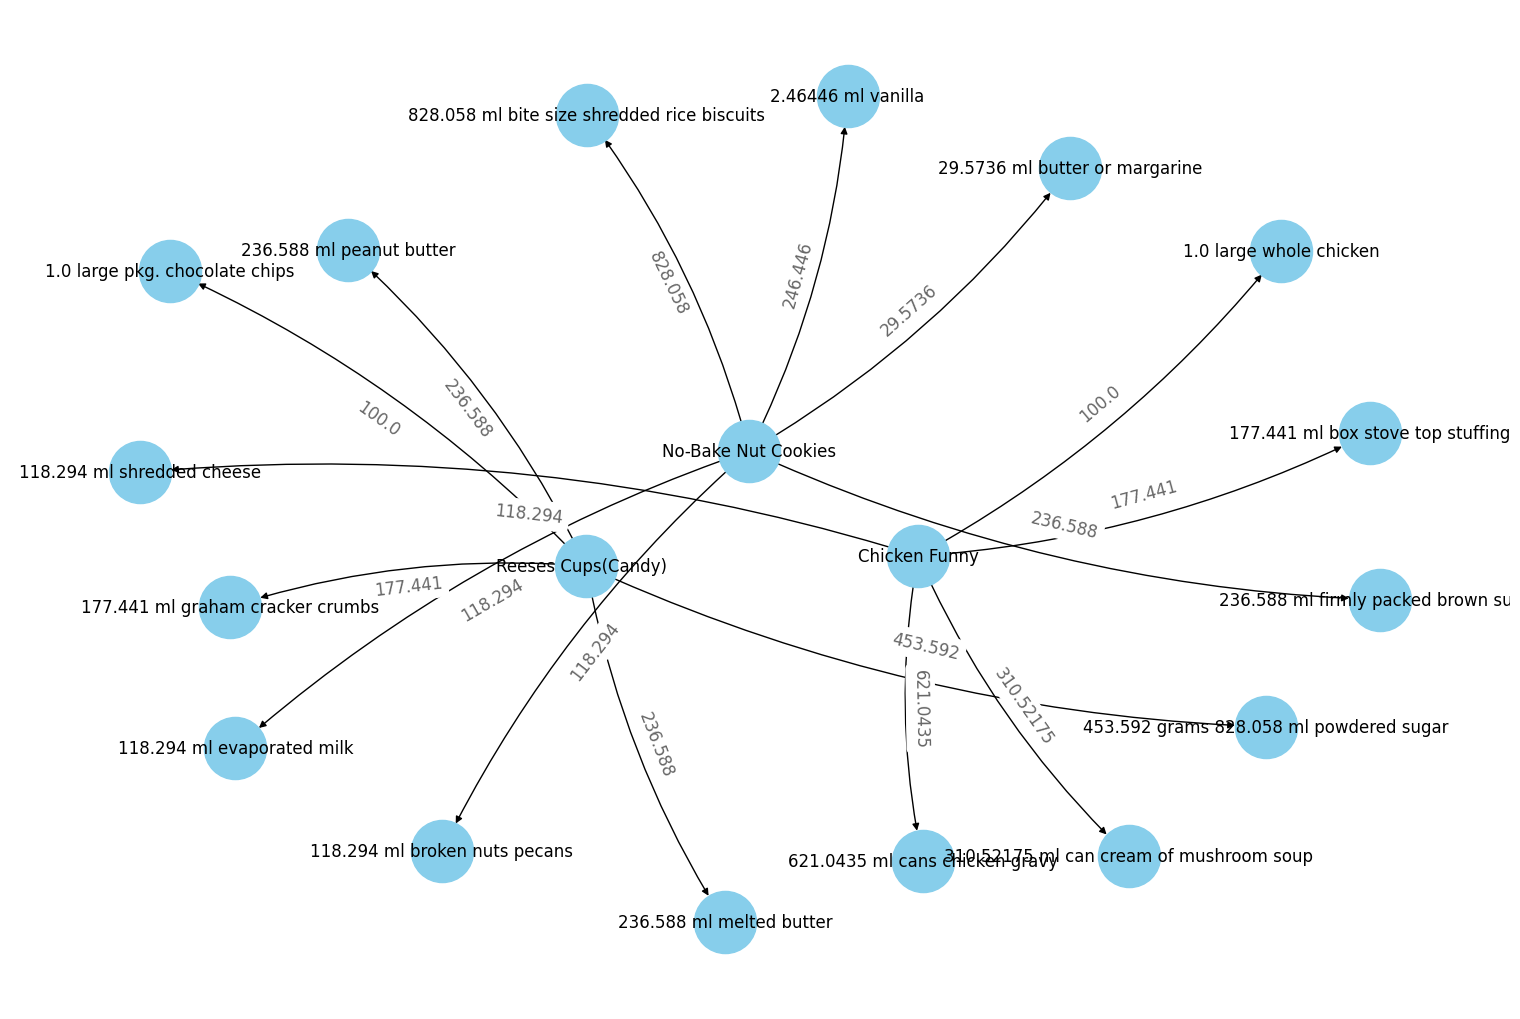

Please zoom-in using your scrollwheel and hover over the nodes and edges


In [58]:
##### DOES NOTHING RIGHT NOW #####

import networkx as nx
from IPython.core.display import HTML
import matplotlib.pyplot as plt
# Create a NetworkX graph
G = nx.Graph()

G = nx.from_pandas_edgelist(example, source="title", target="ingredients", 
                            edge_attr="NER_amount_used", 
                            create_using=nx.DiGraph())


plt.figure(figsize=(15,10))

pos = nx.spring_layout(G, k=1)
node_color = "skyblue"
edge_color = "black"
# draws nodes
nx.draw(G, pos=pos, with_labels=True, node_color=node_color, 
        edge_color=edge_color, cmap=plt.cm.Dark2, 
        node_size=2000, connectionstyle='arc3,rad=0.1')
#draws edges
nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, 
                         edge_labels=nx.get_edge_attributes(G,'NER_amount_used'),
                         font_size=12, font_color='black', alpha=0.6)
plt.show()
print("Please zoom-in using your scrollwheel and hover over the nodes and edges")
# Display the interactive network graph with tooltips in the Jupyter notebook